In [1]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
original_masked = pd.read_csv("/home/pravn/Documents/original_masked_ew_sobject_id_3.csv")

In [3]:
original_masked["sobject_id"].count()

588344

In [4]:
unproblem_ids = pd.read_csv("/home/pravn/Dropbox/unproblem_ids_buder.csv",index_col=0)

In [5]:
df_temp = pd.merge(original_masked , unproblem_ids, how='outer', indicator=True, on="sobject_id")

In [6]:
df_temp["_merge"].value_counts()

both          396338
left_only     192006
right_only        33
Name: _merge, dtype: int64

In [7]:
good_ids = df_temp.loc[df_temp["_merge"]=="both"]

Check Cotar IDs in Good IDs

In [8]:
cotar_classified = pd.read_csv("/home/pravn/Dropbox/Masters/Research Data/results.csv",index_col=0)

In [9]:
good_ids_drop = good_ids.drop(columns=["_merge"],axis=1)

In [10]:
good_ids_drop.head()

,sobject_id,1475,1476,1477,1478,1479,1480,1481,1482,1483,...,1541,1542,1543,1544,1545,1546,1547,1548,1549,EW
0,131116000501002,1.002929,1.020100,1.024491,1.022349,1.012781,0.992014,0.972579,0.980616,1.017553,...,1.000010,1.010591,0.986887,0.998070,1.034840,1.039356,1.017275,1.003299,0.992692,-0.037339
2,131116000501005,0.852568,0.855619,0.852560,0.847285,0.843284,0.833912,0.815157,0.815373,0.822885,...,0.841934,0.837705,0.847344,0.861569,0.875073,0.886794,0.884729,0.878885,0.859658,-0.094523
3,131116000501006,0.799966,0.805414,0.790533,0.784372,0.764509,0.766564,0.785371,0.782442,0.776574,...,0.834315,0.820822,0.824237,0.821758,0.825028,0.833799,0.852333,0.860145,0.859907,-0.087229
4,131116000501007,0.762165,0.753905,0.756847,0.772023,0.768651,0.756399,0.747767,0.750086,0.752324,...,0.821148,0.830479,0.826671,0.820743,0.815063,0.803316,0.793477,0.788137,0.810344,0.076844
7,131116000501012,0.820555,0.817926,0.820356,0.820411,0.803494,0.785131,0.780252,0.787406,0.796942,...,0.845522,0.834277,0.853729,0.873623,0.871357,0.868724,0.857287,0.847043,0.857832,-0.009553


In [11]:
good_ids.head()

,sobject_id,1475,1476,1477,1478,1479,1480,1481,1482,1483,...,1542,1543,1544,1545,1546,1547,1548,1549,EW,_merge
0,131116000501002,1.002929,1.020100,1.024491,1.022349,1.012781,0.992014,0.972579,0.980616,1.017553,...,1.010591,0.986887,0.998070,1.034840,1.039356,1.017275,1.003299,0.992692,-0.037339,both
2,131116000501005,0.852568,0.855619,0.852560,0.847285,0.843284,0.833912,0.815157,0.815373,0.822885,...,0.837705,0.847344,0.861569,0.875073,0.886794,0.884729,0.878885,0.859658,-0.094523,both
3,131116000501006,0.799966,0.805414,0.790533,0.784372,0.764509,0.766564,0.785371,0.782442,0.776574,...,0.820822,0.824237,0.821758,0.825028,0.833799,0.852333,0.860145,0.859907,-0.087229,both
4,131116000501007,0.762165,0.753905,0.756847,0.772023,0.768651,0.756399,0.747767,0.750086,0.752324,...,0.830479,0.826671,0.820743,0.815063,0.803316,0.793477,0.788137,0.810344,0.076844,both
7,131116000501012,0.820555,0.817926,0.820356,0.820411,0.803494,0.785131,0.780252,0.787406,0.796942,...,0.834277,0.853729,0.873623,0.871357,0.868724,0.857287,0.847043,0.857832,-0.009553,both


In [12]:
df_temp_2 = pd.merge(good_ids_drop , cotar_classified, how='outer', indicator=True, on="sobject_id")

In [13]:
df_temp_2["_merge"].value_counts()

left_only     391782
both            4556
right_only      2421
Name: _merge, dtype: int64

DTW on Halpha Cands

In [8]:
good_ids_masked = good_ids[good_ids["EW"]>0.25]

In [9]:
good_ids_masked["EW"].describe()

count    6094.000000
mean        0.591710
std         0.977460
min         0.250012
25%         0.318001
50%         0.422670
75%         0.622047
max        67.883141
Name: EW, dtype: float64

In [10]:
good_ids_masked = good_ids_masked[good_ids_masked["EW"]<50]

In [11]:
good_ids_masked["EW"].describe()

count    6093.000000
mean        0.580666
std         0.460619
min         0.250012
25%         0.317993
50%         0.422652
75%         0.621720
max         5.055410
Name: EW, dtype: float64

<AxesSubplot:>

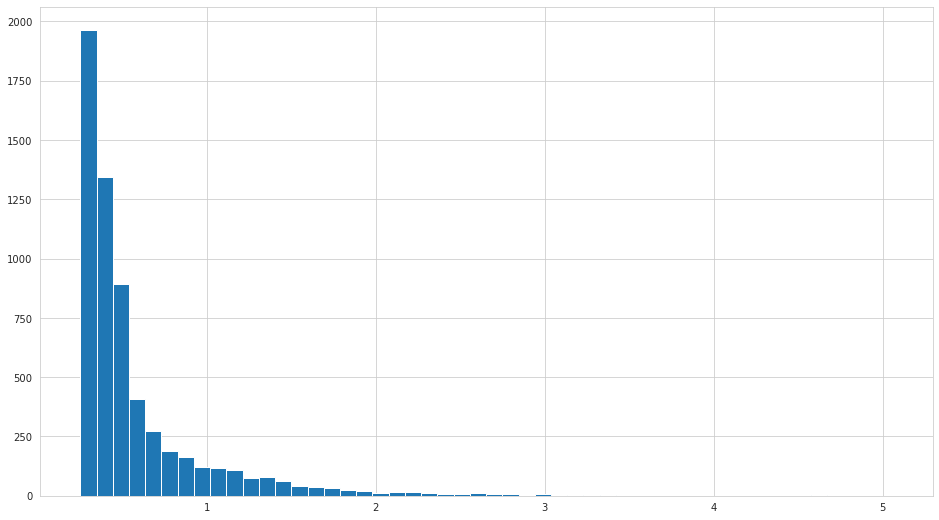

In [13]:
good_ids_masked["EW"].hist(bins=50)

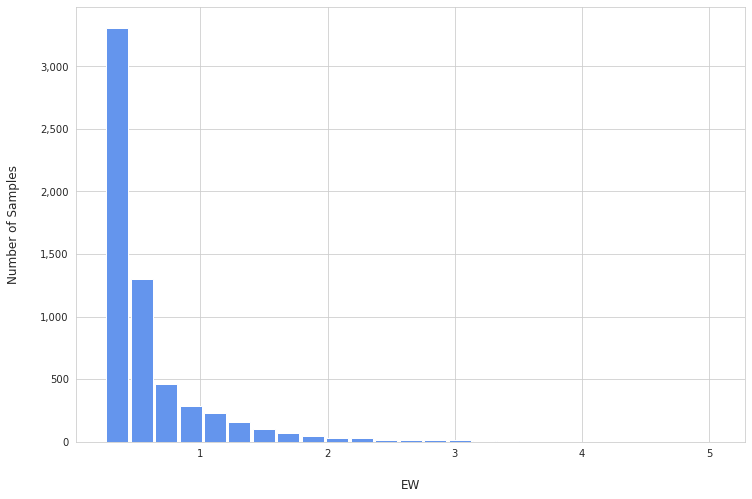

In [14]:
from matplotlib.ticker import StrMethodFormatter
ax = good_ids_masked.hist(column='EW', bins=25, grid=True, figsize=(12,8), color='cornflowerblue', zorder=2, rwidth=0.9, alpha=1)

ax = ax[0]
for x in ax:

    # Despine
    #x.spines['right'].set_visible(False)
    #x.spines['top'].set_visible(False)
    #x.spines['left'].set_visible(False)

    # Switch off ticks
    #x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    #vals = x.get_yticks()
    #for tick in vals:
        #x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("EW", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("Number of Samples", labelpad=20, size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [15]:
good_ids_masked_25_data_only = good_ids_masked.drop(columns=['EW','sobject_id','_merge'])

In [16]:
good_ids_masked_25_data_only_np = good_ids_masked_25_data_only.to_numpy()

In [17]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [18]:
distance_matrix = sd.pdist(good_ids_masked_25_data_only_np, my_fastdtw)

In [18]:
distance_matrix_square_form = sd.squareform(distance_matrix)

In [19]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("Sample")
    plt.ylabel("Sample")
    plt.title("DTW Distance")
    plt.grid()
    plt.legend
    plt.colorbar();

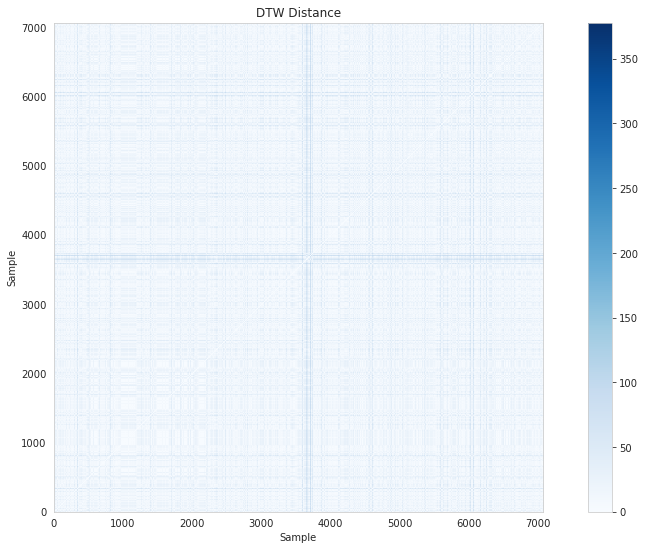

In [20]:
distance_cost_plot(distance_matrix_square_form)

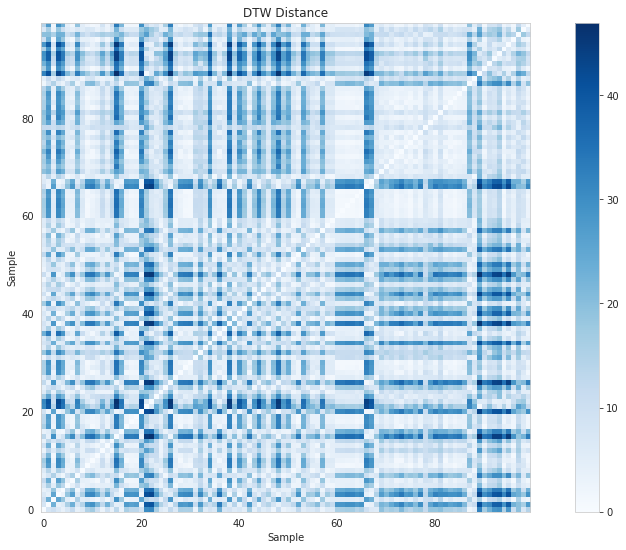

In [21]:
distance_cost_plot(distance_matrix_square_form[0:100:,0:100])

In [64]:
agglom = AgglomerativeClustering(n_clusters = 15, linkage = 'complete', affinity='precomputed') #15 - 126 PC
agglom.fit(distance_matrix_square_form)
agglom.labels_

array([ 6, 14,  6, ...,  8,  6, 14])

In [65]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [66]:
score = silhouette_score(good_ids_masked_25_data_only_np, agglom.labels_)
print(score)

0.33773132517226007


In [67]:
old_names = good_ids_masked_25_data_only.columns.tolist()

In [68]:
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/Research Data/wl_grid.h5", "r")
wl_grid = np.array(hf_grid["wl_grid"])

In [69]:
new_names = wl_grid[PLOT_MASK].tolist()

In [70]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [71]:
good_ids_masked_25_data_only.rename(columns=col_rename_dict, inplace=True)

In [72]:
good_ids_masked_25_data_only["label"] = pd.Series(agglom.labels_, index = good_ids_masked_25_data_only.index)

In [73]:
good_ids_masked_25_data_only["sobject_id"] = good_ids_masked["sobject_id"]

In [74]:
good_ids_masked_25_data_only["label"].value_counts()

8     3292
6     3117
14     411
3      126
9       43
4       36
12      11
5        8
10       7
11       4
7        3
0        3
1        3
2        2
13       1
Name: label, dtype: int64

In [59]:
df_masked = good_ids_masked_25_data_only

Int64Index([130959, 154034, 155785, 155937, 156321, 157602, 157703, 158355,
            209344, 211636, 218024, 275860, 279474, 280165, 280759, 280906,
            281577, 281746, 281946, 281958, 282066, 282115, 282276, 282452,
            282612, 282895, 282986, 283499, 285786, 400662, 475865, 545621,
            552865, 559453, 560060, 560350],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

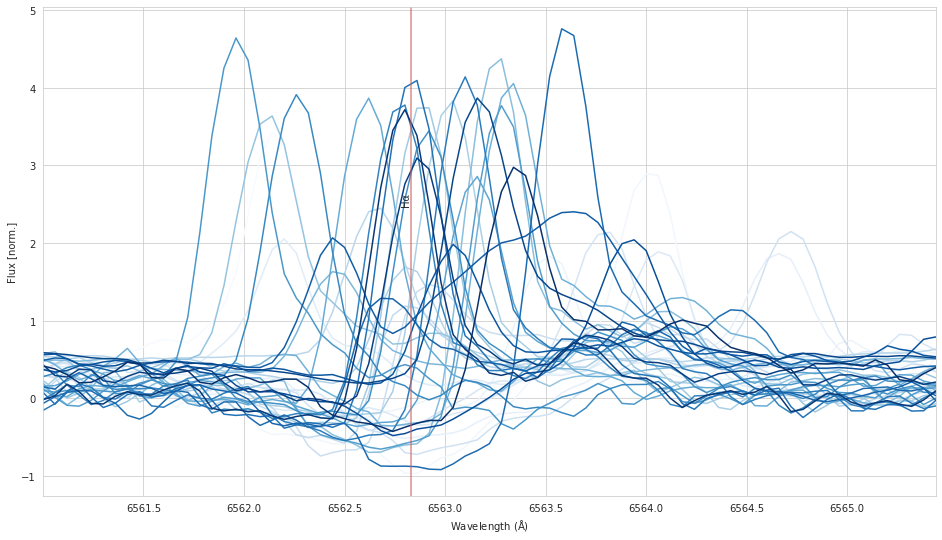

In [82]:
CLASS = 4
df_masked_label = df_masked.loc[df_masked["label"]==CLASS]
print(df_masked_label.index)
ax = (df_masked.loc[df_masked['label'] == CLASS].drop(columns=['label','sobject_id']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Blues"
    )
halpha_line = ax.axvline(x=6562.83, color='indianred', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)

In [35]:
df_masked.head()

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label,sobject_id
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,2,131116001001379
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,2,131118002401234
437,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,0.936088,...,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340,2,131118002401396
477,1.041187,1.057294,1.103539,1.091558,1.097441,1.095028,1.089731,1.095458,1.107621,1.121817,...,1.020609,1.036196,1.027919,1.021646,1.029245,1.032479,1.022374,1.010723,2,131118002901045
501,1.023686,1.030055,1.015542,1.001752,0.998829,1.001729,1.014449,1.024285,1.017944,1.013861,...,1.001805,1.013227,1.000289,0.993298,1.000546,0.989240,0.966034,0.971536,2,131118002901085


In [36]:
df_masked.to_csv("/home/pravn/Dropbox/Masters/Research Data/results_auto.csv")